In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import h5py
import pandas as pd
import numpy as np
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [2]:
f = h5py.File('./data/processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth.z', 'r')
treeArray = f['t_allpar_new'][()]

In [3]:
features = ['j1_ptrel','j1_etarot','j1_phirot','j1_erel','j1_deltaR','j1_pdgid','j_index']
labels = ['j_g','j_q','j_w','j_z','j_t','j_index']

In [4]:
features_df = pd.DataFrame(treeArray,columns=list(set(features)))
labels_df = pd.DataFrame(treeArray,columns=list(set(labels)))
df = pd.concat([features_df,labels_df],axis=1)
df = df.drop_duplicates()

In [44]:
MaxParticles = 20
l1Reg = 0.0001
# Convert to nparray
labels_df = labels_df.drop_duplicates()
features_val = features_df.drop(['j_index'],axis=1).values
labels_val = labels_df.drop(['j_index'],axis=1).values

features_2dval = np.zeros((len(labels_df), MaxParticles, len(features) - 1))
for i in range(0, len(labels_df)):
    features_df_i = features_df[features_df['j_index'] == labels_df['j_index'].iloc[i]]
    index_values = features_df_i.index.values

    features_val_i = features_val[np.array(index_values), :]
    nParticles = len(features_val_i)
    features_val_i = features_val_i[features_val_i[:, 0].argsort()[::-1]]  # sort descending by first value (ptrel, usually)
    
    if nParticles > MaxParticles:
        features_val_i = features_val_i[0:MaxParticles, :]
    else:
        features_val_i = np.concatenate([features_val_i, np.zeros((MaxParticles - nParticles, len(features) - 1))])
    features_2dval[i, :, :] = features_val_i

features_val = features_2dval

In [45]:
X_train_val, X_test, y_train_val, y_test = train_test_split(features_val, labels_val, test_size=0.2,random_state=42)

In [58]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(20,6)))

model.add(layers.GRU(units = 72, activation='selu', recurrent_activation='hard_sigmoid', use_bias=True,
                      kernel_initializer='lecun_uniform', recurrent_initializer='orthogonal',
                      bias_initializer='zeros',  kernel_regularizer=l1(l1Reg),
                      recurrent_regularizer=l1(0.001), bias_regularizer=None, activity_regularizer=None,
                      kernel_constraint=None, recurrent_constraint=None, bias_constraint=None,
#                       dropout=0.001, recurrent_dropout=0.00001,
                     return_sequences=True,name='GRU'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform', 
              name='fc_relu1', kernel_regularizer=l1(l1Reg)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(5, activation='softmax', kernel_initializer='lecun_uniform', 
                        name='output_softmax', kernel_regularizer=l1(l1Reg)))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRU (GRU)                    (None, 20, 72)            17280     
_________________________________________________________________
flatten_8 (Flatten)          (None, 1440)              0         
_________________________________________________________________
fc_relu1 (Dense)             (None, 128)               184448    
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
output_softmax (Dense)       (None, 5)                 645       
Total params: 202,373
Trainable params: 202,373
Non-trainable params: 0
_________________________________________________________________


In [59]:
learningRate = 1e-4
adam = Adam(lr=learningRate)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [60]:
history = model.fit(X_train_val, y_train_val, epochs=30, batch_size=1024, validation_split=0.25, shuffle=True)

Train on 14889 samples, validate on 4963 samples
Epoch 1/30
14889/14889 [==============================] - 6s 426us/sample - loss: 73.0934 - accuracy: 0.6956 - val_loss: 20.8743 - val_accuracy: 0.7516
Epoch 2/30
14889/14889 [==============================] - 2s 162us/sample - loss: 18.8835 - accuracy: 0.8205 - val_loss: 10.7404 - val_accuracy: 0.8598
Epoch 3/30
14889/14889 [==============================] - 2s 161us/sample - loss: 10.3787 - accuracy: 0.8252 - val_loss: 7.4855 - val_accuracy: 0.8628
Epoch 4/30
14889/14889 [==============================] - 2s 160us/sample - loss: 5.2940 - accuracy: 0.8547 - val_loss: 2.1448 - val_accuracy: 0.8837
Epoch 5/30
14889/14889 [==============================] - 2s 156us/sample - loss: 2.1815 - accuracy: 0.8687 - val_loss: 1.4107 - val_accuracy: 0.9083
Epoch 6/30
14889/14889 [==============================] - 2s 154us/sample - loss: 1.3498 - accuracy: 0.8880 - val_loss: 1.0988 - val_accuracy: 0.8976
Epoch 7/30
14889/14889 [======================

Text(0.25, 0.9, 'GRU')

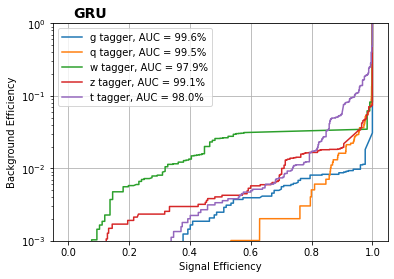

In [61]:
# ROC Plot

if 'j_index' in labels: labels.remove('j_index')

predict_test = model.predict(X_test)

df = pd.DataFrame()

fpr = {}
tpr = {}
auc1 = {}

plt.figure()       
for i, label in enumerate(labels):
    df[label] = y_test[:,i]
    df[label + '_pred'] = predict_test[:,i]

    fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

    auc1[label] = auc(fpr[label], tpr[label])

#     plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
plt.semilogy()
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.legend(loc='upper left')
# plt.xlabel("FPR")
# plt.ylabel("TPR")
# plt.legend(loc='lower right')
plt.ylim(0.001,1)
plt.grid(True)

plt.figtext(0.25, 0.90,'GRU',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)

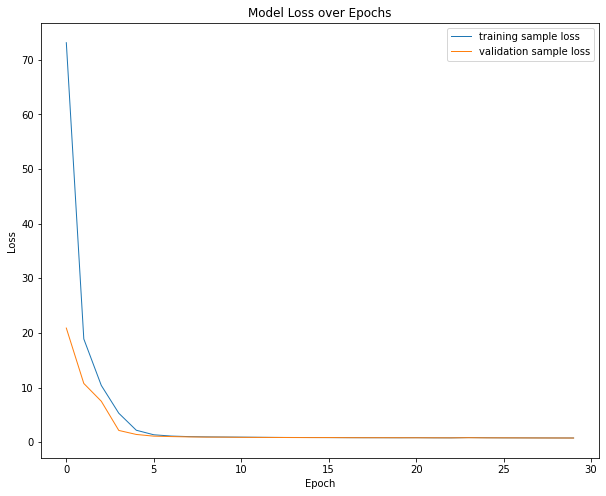

In [62]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], linewidth=1)
plt.plot(history.history['val_loss'], linewidth=1)
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training sample loss','validation sample loss'])
#plt.savefig('Learning_curve.pdf')
plt.show()
plt.close()

## Add more features to  increase the complexity of GRU model.


In [19]:
add_features = ['j_mass_mmdt','j_zlogz', 'j_multiplicity','j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c1_b2_mmdt', 'j_c2_b1_mmdt', 'j_c2_b2_mmdt','j_d2_b1_mmdt','j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt','j_m2_b1_mmdt', 'j_m2_b2_mmdt','j_n2_b1_mmdt', 'j_n2_b2_mmdt']
add_features_df = pd.DataFrame(treeArray,columns=list(set(add_features)))

In [20]:
df = pd.concat([features_df,labels_df,add_features_df],axis=1)
df = df.drop_duplicates()

In [21]:
len(add_features)

16

In [31]:
MaxParticles = 20
l1Reg = 0.0001
# Convert to nparray
features_new_df = pd.concat([features_df,add_features_df],axis=1)
labels_df = labels_df.drop_duplicates()
features_val = features_new_df.drop(['j_index'],axis=1).values
labels_val = labels_df.drop(['j_index'],axis=1).values

features_2dval = np.zeros((len(labels_df), MaxParticles, len(features)+len(add_features) - 1))
for i in range(0, len(labels_df)):
    features_df_i = features_new_df[features_new_df['j_index'] == labels_df['j_index'].iloc[i]]
    index_values = features_df_i.index.values

    features_val_i = features_val[np.array(index_values), :]
    nParticles = len(features_val_i)
    features_val_i = features_val_i[features_val_i[:, 0].argsort()[::-1]]  # sort descending by first value (ptrel, usually)
    
    if nParticles > MaxParticles:
        features_val_i = features_val_i[0:MaxParticles, :]
    else:
        features_val_i = np.concatenate([features_val_i, np.zeros((MaxParticles - nParticles, len(features)+len(add_features) - 1))])
    features_2dval[i, :, :] = features_val_i

features_val = features_2dval

In [32]:
X_train_val, X_test, y_train_val, y_test = train_test_split(features_val, labels_val, test_size=0.2,random_state=42)

In [33]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(20,22)))

model.add(layers.GRU(units = 72, activation='relu', recurrent_activation='sigmoid', use_bias=True,
                      kernel_initializer='lecun_uniform', recurrent_initializer='orthogonal',
                      bias_initializer='zeros',  kernel_regularizer=l1(l1Reg),
                      recurrent_regularizer=l1(0.001), bias_regularizer=None, activity_regularizer=None,
                      kernel_constraint=None, recurrent_constraint=None, bias_constraint=None,
#                       dropout=0.001, recurrent_dropout=0.00001,
                     return_sequences=True,name='GRU'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform', 
              name='fc_relu1', kernel_regularizer=l1(l1Reg)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(5, activation='softmax', kernel_initializer='lecun_uniform', 
                        name='output_softmax', kernel_regularizer=l1(l1Reg)))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRU (GRU)                    (None, 20, 72)            20736     
_________________________________________________________________
flatten_4 (Flatten)          (None, 1440)              0         
_________________________________________________________________
fc_relu1 (Dense)             (None, 128)               184448    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
output_softmax (Dense)       (None, 5)                 645       
Total params: 205,829
Trainable params: 205,829
Non-trainable params: 0
_________________________________________________________________


In [34]:
learningRate = 1e-4
adam = Adam(lr=learningRate)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
history = model.fit(X_train_val, y_train_val, epochs=30, batch_size=1024, validation_split=0.25, shuffle=True)

Train on 14889 samples, validate on 4963 samples
Epoch 1/30
14889/14889 [==============================] - 12s 783us/sample - loss: 58.6234 - accuracy: 0.7090 - val_loss: 17.4682 - val_accuracy: 0.8870
Epoch 2/30
14889/14889 [==============================] - 2s 114us/sample - loss: 10.3732 - accuracy: 0.8665 - val_loss: 4.4859 - val_accuracy: 0.9240
Epoch 3/30
14889/14889 [==============================] - 2s 118us/sample - loss: 4.8775 - accuracy: 0.9020 - val_loss: 2.1493 - val_accuracy: 0.9279
Epoch 4/30
14889/14889 [==============================] - 2s 118us/sample - loss: 3.3228 - accuracy: 0.9190 - val_loss: 2.2482 - val_accuracy: 0.9428
Epoch 5/30
14889/14889 [==============================] - 2s 116us/sample - loss: 2.1873 - accuracy: 0.9126 - val_loss: 1.1952 - val_accuracy: 0.9470
Epoch 6/30
14889/14889 [==============================] - 2s 120us/sample - loss: 1.2083 - accuracy: 0.9285 - val_loss: 0.8719 - val_accuracy: 0.9623
Epoch 7/30
14889/14889 [=======================

Text(0.25, 0.9, 'GRU_more features')

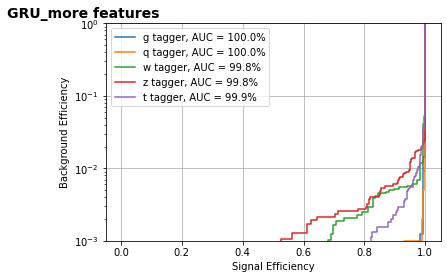

In [39]:
# ROC Plot

if 'j_index' in labels: labels.remove('j_index')

predict_test = model.predict(X_test)

df = pd.DataFrame()

fpr = {}
tpr = {}
auc1 = {}

plt.figure()       
for i, label in enumerate(labels):
    df[label] = y_test[:,i]
    df[label + '_pred'] = predict_test[:,i]

    fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

    auc1[label] = auc(fpr[label], tpr[label])

#     plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
plt.semilogy()
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.legend(loc='upper left')
# plt.xlabel("FPR")
# plt.ylabel("TPR")
# plt.legend(loc='lower right')
plt.ylim(0.001,1)
plt.grid(True)

plt.figtext(0.25, 0.90,'GRU_more features',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)

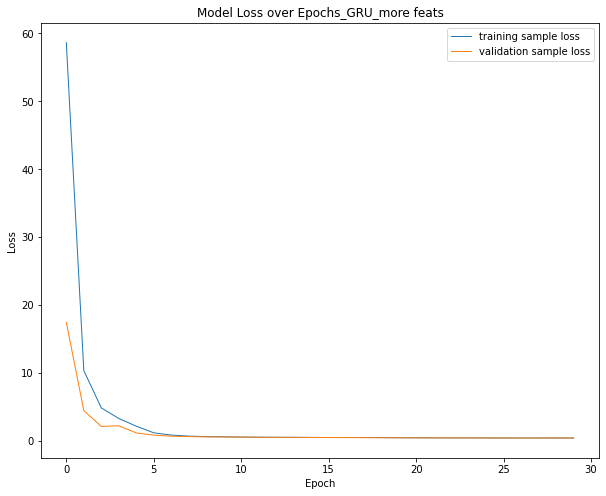

In [37]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], linewidth=1)
plt.plot(history.history['val_loss'], linewidth=1)
plt.title('Model Loss over Epochs_GRU_more feats')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training sample loss','validation sample loss'])
#plt.savefig('Learning_curve.pdf')
plt.show()
plt.close()